# Clasificación de Uso de Suelo y Cobertura del Suelo utilizando Pytorch

**Esta es una obra derivada del original escrito por**: Isabelle Tingzon y Ankur Mahesh

¡Bienvenido al tutorial de CCAI sobre clasificación de uso de suelo y cobertura del suelo (LULC) utilizando Pytorch!

En este tutorial de dos partes, aprenderás a:
- Entrenar un modelo de aprendizaje profundo para clasificación de imágenes utilizando Pytorch
- Generar mapas de uso de suelo y cobertura del suelo utilizando Python GIS

Puedes hacer una copia de este tutorial seleccionando Archivo → Guardar una copia en Drive.


# Tabla de Contenido


*   [Visión General](#resumen)
*   [Impacto Climático](#impacto-climatico)
*   [Público Objetivo](#público-objetivo)
*   [Antecedentes y Requisitos Previos](#antecedentes)
*   [Requisitos de Software](#requisitos-software)
*   [Descripción de datos](#descripción-de-datos)
*   [Metodología](#metodologia)
*   [Resultados](#resultados)
*   [Ejercicios](#ejercicios)
*   [Referencias](#referencias)

<a name="resumen"></a>
# Visión General
Este tutorial cubre una introducción a la clasificación de imágenes utilizando Pytorch para el mapeo de uso del suelo y cobertura terrestre (LULC).

Específicamente, aprenderás cómo:

- Clasificar imágenes satelitales en 10 categorías LULC usando el conjunto de datos [EuroSAT dataset](https://arxiv.org/abs/1709.00029)
- Ajustar finamente un modelo Resnet-50 CNN para clasificación de imágenes
- Guardar y cargar modelos entrenados en Pytorch




<a name="impacto-climatico"></a>
# Impacto Climático
Un [informe](https://www.wri.org/insights/7-things-know-about-ipccs-special-report-climate-change-and-land) del Instituto de Recursos Mundiales (WRI) afirma que alrededor del 23% de las emisiones mundiales de GEI causadas por el hombre proceden de usos del suelo como la agricultura, la silvicultura y la expansión urbana. Los cambios en el uso de la tierra, como la deforestación y la degradación del suelo, están entre los principales causantes de estas emisiones. La rápida urbanización, que conlleva un aumento de las zonas edificadas, así como la pérdida masiva de almacenamiento de carbono terrestre, también pueden provocar grandes emisiones de carbono.

Cartografiar la extensión de las categorías de uso y cobertura del suelo a lo largo del tiempo es esencial para mejorar la vigilancia medioambiental, la planificación urbana y la protección de la naturaleza. Por ejemplo, el seguimiento de los cambios en la cubierta forestal y la identificación de las causas de su pérdida pueden ser útiles para la conservación y restauración de los bosques. La evaluación de la vulnerabilidad de determinados tipos de cubierta terrestre, como los asentamientos y las tierras agrícolas, a determinados riesgos también puede ser útil para la planificación de la reducción del riesgo de catástrofes, así como para los esfuerzos de adaptación climática a largo plazo.

Gracias a la creciente disponibilidad de datos de observación de la Tierra y a los recientes avances en visión por ordenador, la IA y la OE han allanado el camino para cartografiar el uso y la cobertura del suelo a una escala sin precedentes. En este tutorial, exploraremos el uso de imágenes de satélite Sentinel-2 y modelos de aprendizaje profundo en Pytorch para automatizar la cartografía LULC.

<br>
<center><p><p> <img src="https://ptes.org/wp-content/uploads/2018/04/iStock-664630460-e1524839082464.jpg" alt="alt" width="50%"/>




<a name="público-objetivo"></a>
# Público Objetivo
Este tutorial está dirigido a científicos de datos aspirantes y experimentados que buscan ejemplos concretos de las aplicaciones del aprendizaje profundo en el cambio climático. Esperamos que los usuarios tengan cierta experiencia en aprendizaje automático, incluidas las redes neuronales. ¡Pero no te preocupes si eres nuevo en estos temas! Te proporcionaremos recursos adicionales y enlaces externos a continuación para que pueda estudiar más a fondo.

<a name="antecedentes"></a>
## Antecedentes y Requisitos Previos

Para repasar redes neuronales, siéntete libre de ver el video a continuación de [3Blue1Brown](https://www.youtube.com/c/3blue1brown).

También recomendamos encarecidamente la colección de conferencias de [Stanford](https://www.youtube.com/playlist?list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv) sobre redes neuronales convolucionales (CNNs) para el reconocimiento visual. Los cursos de especialización en aprendizaje profundo de [deeplearning.ai](https://www.deeplearning.ai/courses/) también ofrecen una introducción completa a las redes neuronales artificiales (ANNs), CNNs, modelos de secuencias y otros conceptos de aprendizaje profundo.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('P28LKWTzrI')

<a name="requisitos-software"></a>
# Requisitos de Software

Este cuaderno requiere Python >= 3.7. Las siguientes bibliotecas son necesarias:
*   tqdm
*   pandas
*   numpy
*   matplotlib
*   pytorch

## Habilitando GPU en Google Colab

Antes de comenzar, necesitará acceso a una GPU.  Afortunadamente, Google Colab brinda acceso gratuito a recursos informáticos, incluidas las GPU. Las GPU actualmente disponibles en Colab incluyen Nvidia K80, T4, P4 y P100. Desafortunadamente, no hay forma de elegir a qué tipo de GPU puede conectarse en Colab. [Consulte aquí para obtener información](https://research.google.com/colaboratory/faq.html#gpu-availability).

Para habilitar GPU en Google Colab:
1. Vaya a Editar → Configuración del portátil o Tiempo de ejecución → Cambiar tipo de tiempo de ejecución.
2. Seleccione GPU en el menú desplegable Acelerador de hardware.

In [ ]:
# Bibliotecas estándar
import os
import random
from tqdm.notebook import tqdm

# Manipulación y visualización de datos
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Bibliotecas de aprendizaje profundo
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Establecer semillas para la reproducibilidad
SEED = 42
np.random.seed(SEED)

## Google Colab GPU
Comprueba que la GPU está activada en tu cuaderno Colab ejecutando la siguiente celda.

In [ ]:
# Comprueba si la GPU está activada
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Equipo: {}".format(device))

# Obtener un modelo de GPU específico
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Equipo: cuda:0
GPU: Tesla T4


## Subir al drive

Al subir en el drive, el cuaderno de Google Colab podrá cargar archivos de Google Drive y acceder a ellos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<a name="descripción-de-datos"></a>
# Descripción de datos

En esta sección, aprenderá cómo:
- Descargar el conjunto de datos EuroSAT en su Google Drive
- Generar el tren y los conjuntos de prueba dividiendo el conjunto de datos EuroSAT
- Visualizar una muestra de las imágenes y sus etiquetas LULC.

## Conjunto de Datos EuroSAT

El [conjunto de datos EuroSAT](https://github.com/phelber/EuroSAT) contiene 27,000 fragmentos de imágenes satelitales Sentinel-2 etiquetadas de 64x64 píxeles con 10 categorías diferentes de uso del suelo y cobertura terrestre (LULC). Están disponibles imágenes tanto en RGB como multiespectrales (MS) para su descarga. Para simplificar, nos centraremos en la clasificación de imágenes RGB.


In [ ]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2024-12-02 00:06:34--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  19.5MB/s    in 5.7s    

2024-12-02 00:06:40 (15.8 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



## Generar conjuntos de entrenamiento y prueba

### Crear una clase personalizada de conjunto de datos
En Pytorch, la clase `Dataset` permite definir una clase personalizada para cargar la entrada y el objetivo de un conjunto de datos. Utilizaremos esta capacidad para cargar nuestros datos de entrada en forma de imágenes de satélite RGB junto con sus etiquetas correspondientes. Más adelante aprenderemos a aplicar las transformaciones de imagen necesarias (véase la sección siguiente).

In [ ]:
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Aplicar transformaciones de imagen
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Obtener etiqueta de clase
        y = dataset[index][1]
        return x, y

    def __len__(self):
        return len(dataset)

### Aumento de datos

El aumento de datos es una técnica que aplica aleatoriamente transformaciones de imágenes, p. recortes, giros horizontales y giros verticales a las imágenes de entrada durante el entrenamiento del modelo. Estas perturbaciones reducen el sobreajuste de la red neuronal al conjunto de datos de entrenamiento y le permiten generalizar mejor al conjunto de datos de prueba invisible.
<br><br>
<center> <br>
<center> <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/0*ttoU2HOnBI8cb9Y2.png" width="400"/>
<br>
<font size=2>Fuente de la imagen: <a href="https://pranjal-ostwal.medium.com/data-augmentation-for-computer-vision-b88b818b6010">https://pranjal-ostwal.medium.com /aumento-de-datos-para-visión-por-computadora-b88b818b6010</a></a> </font>
<br>
</center>
</center>
<br>
<font size=2>Fuente de la imagen: Ahmad, Jamil & Muhammad, Khan & Baik, Sung. (2017). Aprendizaje profundo asistido por aumento de datos de bocetos dibujados a mano parcialmente coloreados para búsqueda visual. MÁS UNO. 12. e0183838. 10.1371/diario.pone.0183838. </font>
<br>

### Normalización de imagen

Además, en la celda siguiente, el método `transforms.Normalize` normaliza cada uno de los tres canales a las medias y desviaciones estándar dadas definidas en las variables `imagenet_mean` e `imagenet_std`. ImageNet es un gran conjunto de datos de entrenamiento de imágenes y etiquetas.  Más adelante en este tutorial, usaremos un modelo previamente entrenado en este conjunto de datos.  Para utilizar este modelo previamente entrenado para nuestro conjunto de datos LULC, debemos asegurarnos de que el conjunto de datos de entrada esté normalizado para tener las mismas estadísticas (media y desviación estándar) que ImageNet.

<br>
<center> <img src="https://cv.gluon.ai/_images/imagenet_banner.jpeg" width="400"/>
<br>
<font size=2>Fuente de la imagen: <a href=" https://cv.gluon.ai/build/examples_datasets/imagenet.html">https://cv.gluon.ai/build/examples_datasets/imagenet.html</a></font>
<br>
</center>

Las investigaciones existentes han descubierto que el uso de modelos previamente entrenados en conjuntos de datos masivos, como ImageNet, mejora la precisión al aplicar estas redes neuronales a nuevos conjuntos de datos.  Los modelos previamente entrenados sirven como excelentes extractores de características genéricas. [Lea aquí para obtener más información](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).



In [ ]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

### Cargar el Conjunto de Datos EuroSAT

Comencemos cargando el conjunto de datos EuroSAT utilizando la clase `ImageFolder` de torch.

`ImageFolder` es un cargador de datos genérico donde las imágenes están organizadas de la siguiente manera:



```
    data
    └───AnnualCrop
    │   │   AnnualCrop_1.jpg
    │   │   AnnualCrop_2.jpg
    │   │   AnnualCrop_3.jpg
    │   │   ...
    └───Forest
    │   │   Forest_1.jpg
    │   │   Forest_2.jpg
    │   │   Forest_3.jpg
    │   │   ...
```


In [ ]:
# Cargar el conjunto de datos
data_dir = './EuroSAT/2750/'
dataset = datasets.ImageFolder(data_dir)

# Obtener categorías LULC
class_names = dataset.classes
print("Nombres de clase: {}".format(class_names))
print("Número total de clases: {}".format(len(class_names)))

Nombres de clase: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Número total de clases: 10


### División en conjuntos de entrenamiento, validación y prueba
Aquí dividimos el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba. El conjunto de entrenamiento será el 70% del conjunto de datos Eurosat, seleccionado aleatoriamente. Reservamos un 15% del conjunto de datos como conjunto de validación y el 15% restante como conjunto de prueba.

In [ ]:
# Aplicar diferentes transformaciones a los conjuntos de entrenamiento y prueba
train_data = EuroSAT(dataset, train_transform)
val_data = EuroSAT(dataset, val_transform)
test_data = EuroSAT(dataset, test_transform)

# Dividir aleatoriamente el conjunto de datos en 70% entrenamiento / 15% validación / 15% test
# subconjuntando los conjuntos de datos transformados de entrenamiento y prueba
train_size = 0.70
val_size = 0.15
indices = list(range(int(len(dataset))))
train_split = int(train_size * len(dataset))
val_split = int(val_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:train_split])
val_data = data.Subset(val_data, indices=indices[train_split: train_split+val_split])
test_data = data.Subset(test_data, indices=indices[train_split+val_split:])
print("Tamaños de Entrenamiento/Validación/Prueba: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))

Tamaños de Entrenamiento/Validación/Prueba: 18900/4050/4050


Por último, utilizamos la clase `DataLoader` de `torch` para crear un cargador de datos. El cargador de datos gestiona la obtención de muestras de los conjuntos de datos (incluso puede obtenerlas en paralelo utilizando `num_workers`) y ensambla lotes de los conjuntos de datos.

In [ ]:
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
val_loader = data.DataLoader(
    val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

## Visualizar datos

En la celda siguiente, visualizaremos un lote del conjunto de datos.  La celda visualiza la entrada a la red neuronal (la imagen RGB) junto con la etiqueta asociada.

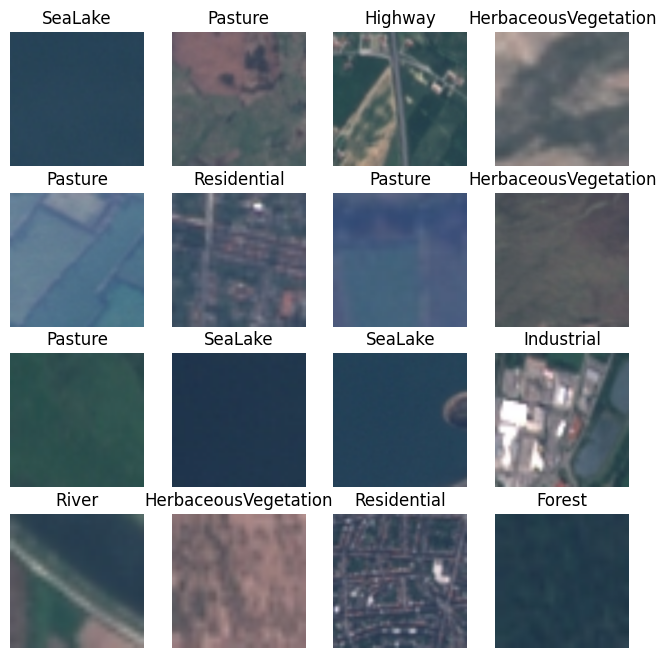

In [ ]:
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8, 8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

# Análisis Exploratorio de Datos

A continuación, exploremos un poco más nuestro conjunto de datos. En particular, ¿cuántas imágenes de cada clase están incluidas?


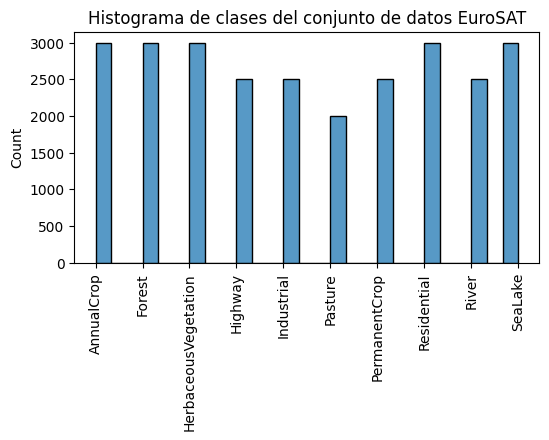

In [ ]:
plt.figure(figsize=(6, 3))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histograma de clases del conjunto de datos EuroSAT')

plt.show()

<a name="metodologia"></a>
# Desarrollo de modelos

## Instanciar el modelo

En primer lugar, vamos a instanciar el modelo. Para empezar, utilizaremos una arquitectura de red neuronal estándar, denominada ResNet50. Basado en [el trabajo de Helber et al.](https://arxiv.org/pdf/1709.00029.pdf), ResNet-50 ha demostrado funcionar bien para la clasificación de LULC en el EuroSAT.

### ResNet-50
<b>Recuperación</b>: Las redes neuronales profundas son difíciles de entrenar debido al problema de los gradientes evanescentes o explosivos (la multiplicación repetida hace que el gradiente sea infinitamente pequeño). ResNet resuelve este problema utilizando conexiones de acceso directo que conectan la activación de una capa anterior a una capa posterior saltándose una o más capas, como se muestra a continuación. Esto permite que los gradientes se propaguen a las capas más profundas antes de que puedan reducirse a valores pequeños o nulos.
<br><br>

<center> <img src="https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/images/resnet50.png" width="600"/><br>
Fuente de la imagen: <a href="https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/">https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/  </a>
</center>
<br>

Observe que cuando cargamos el modelo, establecemos `weights=models.ResNet50_Weights.DEFAULT` para indicar que el modelo cargado debe estar ya preentrenado en el conjunto de datos Imagenet. También modificamos la capa final para que la salida coincida con el número de clases de nuestro conjunto de datos.

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.4MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Formación y evaluación de modelos

Ahora podemos proceder a la formación y evaluación del modelo.

Esta sección tiene tres partes principales:

1. Especifique el criterio, el optimizador y los hiperparámetros (por ejemplo, n_epochs, tasa de aprendizaje, etc.).
2. Entrene el modelo en el conjunto de entrenamiento actualizando sus pesos para minimizar la función de pérdida.
3. Evalúe el modelo en el conjunto de prueba para observar el rendimiento con datos nuevos e invisibles.
4. Repita los pasos 2 y 3 `n_epochs` veces.

### Pérdida de entropía cruzada
Definimos nuestra pérdida como la pérdida de entropía cruzada, que mide el rendimiento de un modelo de clasificación cuya salida es un valor de probabilidad entre 0 y 1. La pérdida de entropía cruzada aumenta a medida que la probabilidad predicha diverge de la etiqueta real. ([Fuente](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html))

Para dos clases, se calcula como:

$−ylog(p)-(1−y)log(1−p)$

Para la clasificación multiclase con $M$ clases, se define como:

$−\sum_{c=1}^{M}y_{o,c}log(p_{o,c})$

donde

- $M$ - número de clases (perro, gato, pez)
- $log$ - el logaritmo natural
- $y_{o,c}$ - indicador binario (0 ó 1) si la etiqueta de clase $c$ es la clasificación para la observación $o$
- $p_{o,c}$ - probabilidad prevista de que la observación $o$ pertenezca a la clase $c$

### Descenso de gradiente estocástico
Recuerde que el objetivo del descenso estocástico por gradiente (SGD) es minimizar la función de pérdida. Para ello, calcula la pendiente (gradiente) de la función de pérdida en el punto actual y se mueve en la dirección opuesta a la pendiente hacia el descenso más pronunciado.
<center> <img src="https://miro.medium.com/max/1400/1*P7z2BKhd0R-9uyn9ThDasA.png" width="350"/><br>Fuente de la imagen:
<a href="https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a">https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a</a>
</center>
<br>

In [ ]:
# Especifique el número de épocas y la tasa de aprendizaje
n_epochs = 10
lr = 1e-3

# Especifique el criterio y el optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

A continuación, vamos a crear nuestra función de entrenamiento.

In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Poner cero a los gradientes de los parámetros
    # Borrar los pesos anteriores en orden
    # para obtener pesos actualizados.
    optimizer.zero_grad()

    # Pase hacia delante
    outputs = model(inputs)

    # Calcular la pérdida
    loss = criterion(outputs, labels)

    # Calcular los gradientes en función de la pérdida
    loss.backward()

    # Actualizar las ponderaciones en función de los
    # gradientes almacenados internamente
    optimizer.step()

    # Calcular estadísticas
    _, preds = torch.max(outputs, 1)

    # Calcular la pérdida de carga y la precisión
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calcular la pérdida de épocas y la precisión
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"Entrenamiento de pérdida: {epoch_loss:.2f}; Precisión: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

A continuación, definamos la función de evaluación del modelo.

In [ ]:
def evaluate(model, dataloader, criterion, phase="val"):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calcular la pérdida de épocas y la precisión
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"{phase.title()} Pérdida: {epoch_loss:.2f}; Precisión: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

En conjunto, definimos la función `fit` para entrenar y evaluar el modelo en el conjunto de entrenamiento y el conjunto de validación, respectivamente.

In [ ]:
def fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer):
  # Mantenga un registro de la mejor pérdida y
  # mejores pesos del modelo con la menor pérdida.
  best_loss = np.inf
  best_model = None

  # Entrenar y probar en n_epocas.
  for epoch in range(n_epochs):
    print("Época {}".format(epoch+1))
    train(model, train_loader, criterion, optimizer)
    val_loss, _ = evaluate(model, val_loader, criterion)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model

  return best_model

Ahora podemos comenzar el entrenamiento y la evaluación del modelo en la siguiente celda.

In [ ]:
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Época 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.72; Precisión: 50.96


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.19; Precisión: 68.67
Época 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.95; Precisión: 71.94


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.69; Precisión: 80.99
Época 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.70; Precisión: 77.99


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.45; Precisión: 87.46
Época 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.58; Precisión: 81.24


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.35; Precisión: 90.42
Época 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.51; Precisión: 83.48


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.28; Precisión: 92.79
Época 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.46; Precisión: 85.04


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.22; Precisión: 93.73
Época 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.42; Precisión: 86.38


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.21; Precisión: 93.85
Época 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.39; Precisión: 87.29


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.17; Precisión: 95.21
Época 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.37; Precisión: 88.11


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.16; Precisión: 95.58
Época 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.35; Precisión: 88.98


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.15; Precisión: 95.68


En el ejemplo anterior, sólo hemos entrenado el modelo durante 10 épocas. En la práctica, deberás entrenar el modelo durante mucho más tiempo para obtener los mejores resultados.

## Rendimiento del Modelo en el Conjunto de Prueba

Usando el mejor modelo de los pasos anteriores, podemos evaluar el rendimiento del modelo en el conjunto de prueba.


In [ ]:
test_loss, _ = evaluate(best_model, test_loader, criterion, phase="test")

  0%|          | 0/254 [00:00<?, ?it/s]

Test Pérdida: 0.16; Precisión: 95.28


## Guardar el Modelo

Definamos una función para guardar el modelo en nuestro Google Drive local de la siguiente manera.



In [ ]:
model_dir = "./drive/My Drive/Colab Notebooks/models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'best_model.pth')
model_file

'./drive/My Drive/Colab Notebooks/models/best_model.pth'

In [ ]:
def save_model(best_model, model_file):
  torch.save(best_model.state_dict(), model_file)
  print('Modelo guardado correctamente en {}.'.format(model_file))

In [ ]:
save_model(best_model, model_file)

Modelo guardado correctamente en ./drive/My Drive/Colab Notebooks/models/best_model.pth.


## Cargar el Modelo

Aquí te mostramos cómo cargar el modelo guardado en el paso anterior.


In [ ]:
def load_model(model_file):
  # Descomente esto para descargar el archivo del modelo.
  #if not os.path.isfile(model_file):
  #  model_file = 'best_model.pth'
  #  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY".

  model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
  model.fc = torch.nn.Linear(model.fc.in_features, 10)
  model.load_state_dict(torch.load(model_file))
  model.eval()

  print('Archivo del modelo {} cargado correctamente.'.format(model_file))
  return model

In [ ]:
model = load_model(model_file)

<ipython-input-22-784979a91fa2>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


Archivo del modelo ./drive/My Drive/Colab Notebooks/models/best_model.pth cargado correctamente.


<a name="resultados"></a>
# Resultados

Visualicemos un ejemplo de la red neuronal haciendo una predicción.

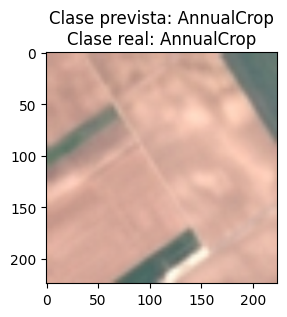

In [ ]:
# Recuperar imagen de muestra.
index = 15
image, label = test_data[index]

# Predecir en la muestra.
model = model.to("cpu")
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Obtener la etiqueta de clase correspondiente.
label = class_names[label]
pred = class_names[pred[0]]

# Visualizar muestra y predicción.
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(image)
ax.set_title("Clase prevista: {}\nClase real: {}".format(pred, label));

A continuación, mostramos cómo ejecutar el modelo en una imagen PIL.

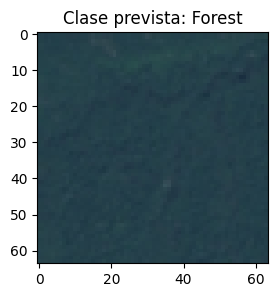

In [ ]:
from PIL import Image
image_path = './EuroSAT/2750/Forest/Forest_2.jpg'
image = Image.open(image_path)

# Transformar imagen.
input = test_transform(image)

# Predecir en la muestra
output = model(input.unsqueeze(0))

# Obtener la etiqueta de clase correspondiente.
_, pred = torch.max(output, 1)
pred = class_names[pred[0]]

# Visualizar resultados.
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(image)
ax.set_title("Clase prevista: {}".format(pred));

<a name="ejercicios"></a>
# Ejercicio 1: Experimenta con una estrategia de ajuste diferente.

Hasta ahora, hemos inicializado la CNN con los pesos de un modelo entrenado en los datos de ImageNet y hemos reentrenado el modelo en el conjunto de datos de EuroSAT actualizando **todos los pesos**. Otro método de ajuste consiste en utilizar las capas convolucionales preentrenadas como un extractor de características fijo y congelar esos pesos, actualizando únicamente los pesos de las capas finales totalmente conectadas para la clasificación.

⭐ **TU TURNO:** Congela todas las capas de un modelo ResNet50 excepto las últimas. ¿Cómo se compara esta estrategia de ajuste con la anterior?

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)

# Congelar todas las capas.
### SU CÓDIGO AQUÍ ###

# Añadir la capa final (no congelada) para la clasificación.
### SU CÓDIGO AQUÍ ###

# Comenzar el entrenamiento.
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Época 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.72; Precisión: 49.67


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.33; Precisión: 63.56
Época 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.95; Precisión: 71.30


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.62; Precisión: 83.88
Época 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.71; Precisión: 77.32


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.45; Precisión: 87.60
Época 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.59; Precisión: 80.77


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.34; Precisión: 90.47
Época 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.52; Precisión: 83.23


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.27; Precisión: 92.54
Época 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.46; Precisión: 85.05


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.23; Precisión: 92.96
Época 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.43; Precisión: 85.89


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.31; Precisión: 90.12
Época 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.41; Precisión: 86.63


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.17; Precisión: 94.94
Época 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.39; Precisión: 87.37


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.16; Precisión: 95.19
Época 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.36; Precisión: 88.53


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.15; Precisión: 95.48


## Solución

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)

# Congelar todas las capas.
for param in model.parameters():
    param.requires_grad = False

# Añadir la capa final (no congelada) para la clasificación.
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)

# Comenzar el entrenamiento.
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Época 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.95; Precisión: 45.53


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.81; Precisión: 60.54
Época 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.55; Precisión: 58.87


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.57; Precisión: 67.58
Época 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.35; Precisión: 64.05


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.37; Precisión: 67.28
Época 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.24; Precisión: 65.85


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.40; Precisión: 65.58
Época 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.16; Precisión: 67.83


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.18; Precisión: 71.33
Época 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.10; Precisión: 69.03


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.14; Precisión: 70.10
Época 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.05; Precisión: 69.67


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.11; Precisión: 73.98
Época 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.01; Precisión: 70.57


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.05; Precisión: 74.17
Época 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.97; Precisión: 71.35


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.07; Precisión: 74.81
Época 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.96; Precisión: 71.76


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.97; Precisión: 75.90


# Ejercicio 2: Experimente con diferentes modelos CNN preentrenados por Imagenet.

ResNet50 es solo una de las muchas arquitecturas diferentes de modelos CNN. Determinar la mejor arquitectura de modelo es una parte importante del proceso de selección de modelos, y en la práctica, es mejor probar y comparar diferentes arquitecturas de modelos. Una descripción detallada de los modelos CNN preentrenados compatibles con Pytorch se puede encontrar aquí: https://pytorch.org/vision/0.18/models.html

⭐ **¡TU TURNO!:** Prueba un modelo CNN preentrenado diferente de Pytorch, basado en los modelos disponibles que se encuentran [aquí](https://pytorch.org/vision/0.18/models.html). ¿Qué tan bien funciona en comparación con ResNet50?

Asegúrate de modificar la última capa para la clasificación para que coincida con el número de clases (Pista: el número de clases = `len(dataset.classes)`).


In [ ]:
model = ### SU CÓDIGO AQUÍ ###

# Modificar la capa final para la clasificación.
### SU CÓDIGO AQUÍ ###

model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

SyntaxError: invalid syntax (<ipython-input-28-adc5c324980c>, line 1)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Época 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.93; Precisión: 72.47


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.93; Precisión: 76.27
Época 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.92; Precisión: 72.55


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.94; Precisión: 75.11
Época 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.90; Precisión: 72.84


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.94; Precisión: 74.77
Época 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.89; Precisión: 72.42


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.90; Precisión: 76.22
Época 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.87; Precisión: 73.48


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.91; Precisión: 75.43
Época 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.86; Precisión: 73.77


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.90; Precisión: 76.94
Época 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.83; Precisión: 74.53


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.88; Precisión: 76.22
Época 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.83; Precisión: 74.14


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.84; Precisión: 78.30
Época 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.82; Precisión: 74.62


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.86; Precisión: 75.93
Época 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.80; Precisión: 75.43


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.81; Precisión: 78.86


## Solución

Aquí elegimos EfficientNet-B0 como el modelo para entrenar y evaluar. Más información sobre EfficientNets se puede encontrar [aquí](https://arxiv.org/pdf/1905.11946).

In [ ]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Modificar la capa final para la clasificación.
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(dataset.classes))

model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 48.0MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [ ]:
# Comenzar el entrenamiento
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Época 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.69; Precisión: 52.88


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.25; Precisión: 71.14
Época 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.03; Precisión: 70.92


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.66; Precisión: 85.06
Época 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.80; Precisión: 75.95


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.58; Precisión: 86.07
Época 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.67; Precisión: 78.89


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.41; Precisión: 88.89
Época 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.58; Precisión: 81.47


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.29; Precisión: 91.80
Época 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.54; Precisión: 82.63


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.22; Precisión: 94.10
Época 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.50; Precisión: 83.77


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.23; Precisión: 93.51
Época 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.48; Precisión: 84.48


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.19; Precisión: 94.20
Época 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.46; Precisión: 85.03


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.19; Precisión: 93.95
Época 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.43; Precisión: 86.24


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.16; Precisión: 94.79


# Ejercicio 3: Experimente con modelos CNN previamente entrenados con imágenes de satélite.

Los profesionales tradicionalmente han confiado en modelos previamente entrenados por Imagenet para transferir tareas de aprendizaje, incluso para datos de observación de la Tierra. Sin embargo, con la creciente disponibilidad de datos de teledetección, ahora vemos que cada vez se seleccionan más conjuntos de datos de teledetección a gran escala para el entrenamiento previo de modelos, como [SSL4EO-S12](https://github.com/zhu-xlab/SSL4EO-S12) por Wang et al. Los modelos entrenados en estos conjuntos de datos utilizan técnicas de aprendizaje autosupervisadas o no supervisadas, aprovechando las grandes cantidades de datos de teledetección sin procesar y sin etiquetar para el entrenamiento previo del modelo.

Se puede acceder a estos pesos previamente entrenados a través de la [Torchgeo library](https://github.com/microsoft/torchgeo). Puede encontrar más información sobre los pesos previamente entrenados disponibles aquí:  https://torchgeo.readthedocs.io/en/stable/api/models.html#pretrained-weights





⭐ **¡TU TURNO!:** Utilizando torchgeo, cargue un modelo ResNet50 previamente entrenado de Sentinel-2 y ajuste el modelo actualizando **todos los pesos**. ¿Cómo se compara este modelo con el modelo ResNet50 previamente entrenado con Imagenet?



In [ ]:
!pip install -q timm
!pip install -q torchgeo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.5/454.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.1/845.1 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 34.4 MB/s eta 

In [ ]:
import timm
from torchgeo.models import ResNet50_Weights

model = ### TU CÓDIGO AQUÍ ###

model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

In [ ]:
# Comenzar a entrenar.
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

## Solution

In [ ]:
import timm
from torchgeo.models import ResNet50_Weights

weights = ResNet50_Weights.SENTINEL2_RGB_MOCO
model = timm.create_model(
    "resnet50", in_chans=weights.meta["in_chans"],
    num_classes=len(dataset.classes)
)
model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

Downloading: "https://hf.co/torchgeo/resnet50_sentinel2_rgb_moco/resolve/efd9723b59a88e9dc1420dc1e96afb25b0630a3c/resnet50_sentinel2_rgb_moco-2b57ba8b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_sentinel2_rgb_moco-2b57ba8b.pth
100%|██████████| 90.0M/90.0M [00:00<00:00, 137MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Identity-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
         Identity-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# comenzar a entrenar.
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Época 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 2.28; Precisión: 34.87


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 2.23; Precisión: 49.04
Época 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 2.18; Precisión: 46.71


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 2.05; Precisión: 45.83
Época 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.94; Precisión: 44.92


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.65; Precisión: 51.31
Época 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.64; Precisión: 50.56


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.32; Precisión: 63.83
Época 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.41; Precisión: 58.60


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 1.08; Precisión: 73.68
Época 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.21; Precisión: 66.76


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.87; Precisión: 80.44
Época 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 1.02; Precisión: 72.33


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.65; Precisión: 85.56
Época 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.85; Precisión: 76.88


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.48; Precisión: 88.47
Época 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.73; Precisión: 79.63


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.34; Precisión: 91.68
Época 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Entrenamiento de pérdida: 0.62; Precisión: 82.31


  0%|          | 0/254 [00:00<?, ?it/s]

Val Pérdida: 0.27; Precisión: 93.98


¡Felicitaciones por llegar hasta aquí! Ir a la siguiente sección, [Parte 2: Automatización del mapeo de uso y cobertura del suelo usando Python.](https://colab.research.google.com/drive/13I1wZT7thBlNdGA1tFQrK1MlRhMZMnpM?usp=sharing).

<a name="referencias"></a>
# Referencias
- Helber, P., Bischke, B., Dengel, A., & Borth, D. (2019). Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 12(7), 2217-2226.
- Wang, Y., Braham, N. A. A., Xiong, Z., Liu, C., Albrecht, C. M., & Zhu, X. X. (2023). SSL4EO-S12: A large-scale multimodal, multitemporal dataset for self-supervised learning in Earth observation [Software and Data Sets]. IEEE Geoscience and Remote Sensing Magazine, 11(3), 98-106.